# **Modélisation statistique**
Nous allons mener des régressions linéaires de la production électrique éolienne (données API RTE) sur les données météorologiques de vents (données API ...)

Dans un premier temps, nous allons créer un data frame qui contiendra la moyenne nationale de la production électrique éolienne ainsi que la moyenne des vents nationaux, heure par heure pour l'année 2021.
Ensuite, nous affinerons l'analyse en faisant des régressions par région/année.

### **1) Récupération des données**

Dans un premier temps, nous cherchons à mettre les dates des données météorologique et des données RTE dans le même format. Le format cherché est, par exemple pour le 5 mai 2020 à 12h:

**2020-05-05:12:00**

#### **a) Données météorologiques**

In [40]:
import pandas as pd

In [41]:
donnees_vent = pd.read_csv(r'C:\Users\peign\Desktop\ProjetPython\donnees_vent.csv', sep=",", names=['Index', 'Time', 'Windspeed'])

In [42]:
donnees_vent.head()

,Index,Time,Windspeed
0,0,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86..."
1,1,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
2,2,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
3,3,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
4,12,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.66, 1.88, 1.97, 2.25, 1.43, 1.51, 1.43, 1.3..."


Le format des données est le suivant:

-L'index représente le numéro des éoliennes, numérotées de 0 à XXXX.

-La variable "Time" contient la liste de toutes les dates auxquelles on observe la vitesse du vent à la position de l'éolienne.

-La variable "Windspeed" contient la liste de la vitesse des vents.

Dans un premier temps, on va chercher à "nettoyer" la variable "Time" afin de créer une liste de dates harmonisées.

In [43]:
donnees_vent["Time"][0]

"['2021-01-01T00:00', '2021-01-01T01:00', '2021-01-01T02:00', '2021-01-01T03:00', '2021-01-01T04:00', '2021-01-01T05:00', '2021-01-01T06:00', '2021-01-01T07:00', '2021-01-01T08:00', '2021-01-01T09:00', '2021-01-01T10:00', '2021-01-01T11:00', '2021-01-01T12:00', '2021-01-01T13:00', '2021-01-01T14:00', '2021-01-01T15:00', '2021-01-01T16:00', '2021-01-01T17:00', '2021-01-01T18:00', '2021-01-01T19:00', '2021-01-01T20:00', '2021-01-01T21:00', '2021-01-01T22:00', '2021-01-01T23:00', '2021-01-02T00:00', '2021-01-02T01:00', '2021-01-02T02:00', '2021-01-02T03:00', '2021-01-02T04:00', '2021-01-02T05:00', '2021-01-02T06:00', '2021-01-02T07:00', '2021-01-02T08:00', '2021-01-02T09:00', '2021-01-02T10:00', '2021-01-02T11:00', '2021-01-02T12:00', '2021-01-02T13:00', '2021-01-02T14:00', '2021-01-02T15:00', '2021-01-02T16:00', '2021-01-02T17:00', '2021-01-02T18:00', '2021-01-02T19:00', '2021-01-02T20:00', '2021-01-02T21:00', '2021-01-02T22:00', '2021-01-02T23:00', '2021-01-03T00:00', '2021-01-03T01:00'

In [8]:
type(donnees_vent["Time"][0])

str

In [44]:
caracteres_time = ["'","[","]","T", ","]
    
for string in caracteres_time:
    donnees_vent["Time"] = donnees_vent["Time"].apply(lambda x: x.replace(string, ''))

In [10]:
donnees_vent["Time"][0]

'2021-01-0100:00 2021-01-0101:00 2021-01-0102:00 2021-01-0103:00 2021-01-0104:00 2021-01-0105:00 2021-01-0106:00 2021-01-0107:00 2021-01-0108:00 2021-01-0109:00 2021-01-0110:00 2021-01-0111:00 2021-01-0112:00 2021-01-0113:00 2021-01-0114:00 2021-01-0115:00 2021-01-0116:00 2021-01-0117:00 2021-01-0118:00 2021-01-0119:00 2021-01-0120:00 2021-01-0121:00 2021-01-0122:00 2021-01-0123:00 2021-01-0200:00 2021-01-0201:00 2021-01-0202:00 2021-01-0203:00 2021-01-0204:00 2021-01-0205:00 2021-01-0206:00 2021-01-0207:00 2021-01-0208:00 2021-01-0209:00 2021-01-0210:00 2021-01-0211:00 2021-01-0212:00 2021-01-0213:00 2021-01-0214:00 2021-01-0215:00 2021-01-0216:00 2021-01-0217:00 2021-01-0218:00 2021-01-0219:00 2021-01-0220:00 2021-01-0221:00 2021-01-0222:00 2021-01-0223:00 2021-01-0300:00 2021-01-0301:00 2021-01-0302:00 2021-01-0303:00 2021-01-0304:00 2021-01-0305:00 2021-01-0306:00 2021-01-0307:00 2021-01-0308:00 2021-01-0309:00 2021-01-0310:00 2021-01-0311:00 2021-01-0312:00 2021-01-0313:00 2021-01

In [11]:
donnees_vent["Windspeed"][0]

'[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86, 2.78, 2.86, 2.66, 3.0, 3.11, 3.36, 3.52, 3.14, 2.33, 1.61, 2.01, 1.8, 1.82, 2.0, 1.1, 0.58, 0.0, 0.45, 1.42, 1.42, 0.94, 1.12, 0.85, 0.81, 0.78, 0.64, 0.41, 0.91, 1.4, 1.81, 2.06, 1.93, 1.97, 2.48, 2.8, 2.51, 1.97, 1.49, 1.33, 1.84, 1.77, 1.25, 1.28, 1.39, 0.89, 1.25, 1.64, 1.88, 2.06, 2.47, 3.04, 3.71, 3.52, 3.57, 3.38, 3.27, 2.73, 2.56, 2.9, 3.18, 3.11, 2.9, 2.86, 2.72, 2.69, 2.66, 2.78, 2.64, 2.78, 2.82, 3.0, 2.92, 2.88, 2.97, 3.42, 3.85, 3.64, 3.35, 2.66, 2.76, 2.69, 2.58, 2.8, 3.06, 3.11, 2.78, 2.83, 2.95, 3.09, 3.28, 3.3, 3.08, 2.92, 2.73, 2.72, 2.63, 2.6, 2.92, 2.81, 3.61, 3.74, 3.76, 3.08, 2.52, 1.92, 1.84, 2.2, 2.42, 2.55, 2.42, 2.2, 2.11, 1.97, 1.8, 1.66, 1.57, 1.49, 1.55, 1.58, 1.52, 1.26, 1.61, 1.32, 2.11, 2.27, 2.14, 2.0, 1.39, 0.81, 1.12, 1.21, 1.5, 1.43, 1.14, 0.22, 0.1, 0.2, 0.2, 0.22, 0.58, 1.06, 1.08, 1.24, 0.85, 0.7, 1.14, 1.12, 1.25, 0.95, 1.48, 1.66, 1.42, 1.08, 1.32, 1.6, 1.8, 2.0, 1.91, 1.63, 1.61, 1.5, 1.9, 2.02, 

In [45]:
caracteres_vent = ["[", "]", ","]

for string in caracteres_vent:
    donnees_vent["Windspeed"] = donnees_vent["Windspeed"].apply(lambda x: x.replace(string, ''))

In [13]:
donnees_vent["Windspeed"][0]

'1.43 1.25 1.7 2.02 2.08 2.42 2.64 2.86 2.78 2.86 2.66 3.0 3.11 3.36 3.52 3.14 2.33 1.61 2.01 1.8 1.82 2.0 1.1 0.58 0.0 0.45 1.42 1.42 0.94 1.12 0.85 0.81 0.78 0.64 0.41 0.91 1.4 1.81 2.06 1.93 1.97 2.48 2.8 2.51 1.97 1.49 1.33 1.84 1.77 1.25 1.28 1.39 0.89 1.25 1.64 1.88 2.06 2.47 3.04 3.71 3.52 3.57 3.38 3.27 2.73 2.56 2.9 3.18 3.11 2.9 2.86 2.72 2.69 2.66 2.78 2.64 2.78 2.82 3.0 2.92 2.88 2.97 3.42 3.85 3.64 3.35 2.66 2.76 2.69 2.58 2.8 3.06 3.11 2.78 2.83 2.95 3.09 3.28 3.3 3.08 2.92 2.73 2.72 2.63 2.6 2.92 2.81 3.61 3.74 3.76 3.08 2.52 1.92 1.84 2.2 2.42 2.55 2.42 2.2 2.11 1.97 1.8 1.66 1.57 1.49 1.55 1.58 1.52 1.26 1.61 1.32 2.11 2.27 2.14 2.0 1.39 0.81 1.12 1.21 1.5 1.43 1.14 0.22 0.1 0.2 0.2 0.22 0.58 1.06 1.08 1.24 0.85 0.7 1.14 1.12 1.25 0.95 1.48 1.66 1.42 1.08 1.32 1.6 1.8 2.0 1.91 1.63 1.61 1.5 1.9 2.02 2.02 2.04 1.84 2.02 2.28 2.39 1.49 1.66 1.93 2.31 2.4 2.24 1.6 2.25 2.41 2.22 1.84 2.01 2.15 1.88 1.75 1.91 1.9 1.84 1.66 1.78 2.47 2.83 3.28 3.54 3.96 3.8 4.19 4.6 6.46 5.

In [14]:
donnees_vent.head()

,Index,Time,Windspeed
0,0,2021-01-0100:00 2021-01-0101:00 2021-01-0102:0...,1.43 1.25 1.7 2.02 2.08 2.42 2.64 2.86 2.78 2....
1,1,2021-01-0100:00 2021-01-0101:00 2021-01-0102:0...,2.1 2.18 2.22 2.18 1.66 1.75 1.7 1.71 1.49 1.6...
2,2,2021-01-0100:00 2021-01-0101:00 2021-01-0102:0...,2.1 2.18 2.22 2.18 1.66 1.75 1.7 1.71 1.49 1.6...
3,3,2021-01-0100:00 2021-01-0101:00 2021-01-0102:0...,2.1 2.18 2.22 2.18 1.66 1.75 1.7 1.71 1.49 1.6...
4,12,2021-01-0100:00 2021-01-0101:00 2021-01-0102:0...,1.66 1.88 1.97 2.25 1.43 1.51 1.43 1.33 1.46 1...


Maintenant que les variables "Time" et "Windspeed" sont nettoyées, on va utiliser la fonction explode afin d'avoir une base de données "classique" pour pouvoir faire des régressions. Nous allons étendre les listes afin que chaque vent soit associé à une date précise.

Premièrement, on convertit nos données considérés comme "string" en liste.

In [46]:
donnees_vent["Time"] = donnees_vent["Time"].str.split(' ')
donnees_vent["Time"] = donnees_vent["Time"].tolist()

In [47]:
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].str.split(' ')
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].tolist()

In [17]:
donnees_vent.head()

,Index,Time,Windspeed
0,0,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86..."
1,1,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
2,2,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
3,3,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
4,12,"[2021-01-0100:00, 2021-01-0101:00, 2021-01-010...","[1.66, 1.88, 1.97, 2.25, 1.43, 1.51, 1.43, 1.3..."


In [18]:
donnees_vent["Time"][0]

['2021-01-0100:00',
 '2021-01-0101:00',
 '2021-01-0102:00',
 '2021-01-0103:00',
 '2021-01-0104:00',
 '2021-01-0105:00',
 '2021-01-0106:00',
 '2021-01-0107:00',
 '2021-01-0108:00',
 '2021-01-0109:00',
 '2021-01-0110:00',
 '2021-01-0111:00',
 '2021-01-0112:00',
 '2021-01-0113:00',
 '2021-01-0114:00',
 '2021-01-0115:00',
 '2021-01-0116:00',
 '2021-01-0117:00',
 '2021-01-0118:00',
 '2021-01-0119:00',
 '2021-01-0120:00',
 '2021-01-0121:00',
 '2021-01-0122:00',
 '2021-01-0123:00',
 '2021-01-0200:00',
 '2021-01-0201:00',
 '2021-01-0202:00',
 '2021-01-0203:00',
 '2021-01-0204:00',
 '2021-01-0205:00',
 '2021-01-0206:00',
 '2021-01-0207:00',
 '2021-01-0208:00',
 '2021-01-0209:00',
 '2021-01-0210:00',
 '2021-01-0211:00',
 '2021-01-0212:00',
 '2021-01-0213:00',
 '2021-01-0214:00',
 '2021-01-0215:00',
 '2021-01-0216:00',
 '2021-01-0217:00',
 '2021-01-0218:00',
 '2021-01-0219:00',
 '2021-01-0220:00',
 '2021-01-0221:00',
 '2021-01-0222:00',
 '2021-01-0223:00',
 '2021-01-0300:00',
 '2021-01-0301:00',


In [75]:
donnees_vent["Windspeed"][0]

['1.43',
 '1.25',
 '1.7',
 '2.02',
 '2.08',
 '2.42',
 '2.64',
 '2.86',
 '2.78',
 '2.86',
 '2.66',
 '3.0',
 '3.11',
 '3.36',
 '3.52',
 '3.14',
 '2.33',
 '1.61',
 '2.01',
 '1.8',
 '1.82',
 '2.0',
 '1.1',
 '0.58',
 '0.0',
 '0.45',
 '1.42',
 '1.42',
 '0.94',
 '1.12',
 '0.85',
 '0.81',
 '0.78',
 '0.64',
 '0.41',
 '0.91',
 '1.4',
 '1.81',
 '2.06',
 '1.93',
 '1.97',
 '2.48',
 '2.8',
 '2.51',
 '1.97',
 '1.49',
 '1.33',
 '1.84']

In [48]:
donnees_vent = donnees_vent.set_index(['Index']).apply(pd.Series.explode).reset_index()

In [20]:
donnees_vent

,Index,Time,Windspeed
0,0,2021-01-0100:00,1.43
1,0,2021-01-0101:00,1.25
2,0,2021-01-0102:00,1.7
3,0,2021-01-0103:00,2.02
4,0,2021-01-0104:00,2.08
...,...,...,...
2899099,7469,2021-01-3119:00,4.66
2899100,7469,2021-01-3120:00,5.52
2899101,7469,2021-01-3121:00,6.1
2899102,7469,2021-01-3122:00,5.69


In [49]:
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].astype(float)
donnees_vent["Index"] = donnees_vent["Index"].astype(str)

In [50]:
vent_moyen = donnees_vent.groupby(['Time']).mean()
vent_moyen.count()

Windspeed    3624
dtype: int64

In [51]:
vent_moyen

,Windspeed
Time,
2021-01-0100:00,1.806369
2021-01-0101:00,1.877788
2021-01-0102:00,1.917985
2021-01-0103:00,1.907239
2021-01-0104:00,1.931925
...,...
2021-05-3119:00,2.668844
2021-05-3120:00,2.870169
2021-05-3121:00,3.022010


#### **b) Données RTE**
On importe les données RTE auparavant obtenu grâce à une API.

**Pour l'instant:** données test de Janvier à Février 2020

In [64]:
data_RTE = pd.read_csv('RTE_test.csv')

In [65]:
data_RTE

,Unnamed: 0,start_date,end_date,updated_date,value
0,0,2021-01-01 00:00:00+01:00,2021-01-01 01:00:00+01:00,2021-01-01T00:40:58+01:00,1082
1,1,2021-01-01 01:00:00+01:00,2021-01-01 02:00:00+01:00,2021-01-01T01:40:58+01:00,1075
2,2,2021-01-01 02:00:00+01:00,2021-01-01 03:00:00+01:00,2021-01-01T02:40:55+01:00,1086
3,3,2021-01-01 03:00:00+01:00,2021-01-01 04:00:00+01:00,2021-01-01T03:40:57+01:00,1149
4,4,2021-01-01 04:00:00+01:00,2021-01-01 05:00:00+01:00,2021-01-01T04:40:54+01:00,1170
...,...,...,...,...,...
3618,3618,2021-05-31 19:00:00+02:00,2021-05-31 20:00:00+02:00,2021-05-31T18:38:14+02:00,2304
3619,3619,2021-05-31 20:00:00+02:00,2021-05-31 21:00:00+02:00,2021-05-31T19:33:04+02:00,2316
3620,3620,2021-05-31 21:00:00+02:00,2021-05-31 22:00:00+02:00,2021-05-31T20:34:02+02:00,2845
3621,3621,2021-05-31 22:00:00+02:00,2021-05-31 23:00:00+02:00,2021-05-31T21:33:59+02:00,3840


On renomme les trois colonnes nécessaires et on enlève les colonnes inutiles

In [66]:
columns_to_drop = ['end_date', 'updated_date']
data_RTE = data_RTE.drop(columns_to_drop, axis=1)

columns_to_rename = {'Unnamed: 0': 'Index', 'start_date': 'Time', 'value': 'Electricity'}
data_RTE = data_RTE.rename(columns=columns_to_rename)

On enlève les éléments de la date inutile afin d'harmoniser

In [67]:
caracteres = ["+01:00"," ","+02:00"]
    
for string in caracteres:
    data_RTE["Time"] = data_RTE["Time"].apply(lambda x: x.replace(string, ''))

data_RTE["Time"] = data_RTE["Time"].str[:-3]

In [68]:
data_RTE

,Index,Time,Electricity
0,0,2021-01-0100:00,1082
1,1,2021-01-0101:00,1075
2,2,2021-01-0102:00,1086
3,3,2021-01-0103:00,1149
4,4,2021-01-0104:00,1170
...,...,...,...
3618,3618,2021-05-3119:00,2304
3619,3619,2021-05-3120:00,2316
3620,3620,2021-05-3121:00,2845
3621,3621,2021-05-3122:00,3840


Les dates sont bien au format harmonisé voulu.

#### **c) Merge des deux database**

In [69]:
data = data_RTE.merge(vent_moyen, on='Time')
data["Windspeed_cubed"] = data["Windspeed"].pow(3)

In [70]:
data

,Index,Time,Electricity,Windspeed,Windspeed_cubed
0,0,2021-01-0100:00,1082,1.806369,5.894126
1,1,2021-01-0101:00,1075,1.877788,6.621249
2,2,2021-01-0102:00,1086,1.917985,7.055622
3,3,2021-01-0103:00,1149,1.907239,6.937694
4,4,2021-01-0104:00,1170,1.931925,7.210592
...,...,...,...,...,...
3618,3618,2021-05-3119:00,2304,2.668844,19.009447
3619,3619,2021-05-3120:00,2316,2.870169,23.644074
3620,3620,2021-05-3121:00,2845,3.022010,27.598643
3621,3621,2021-05-3122:00,3840,3.150657,31.275449


### **2) Les régressions**
#### **Régression linéaire**

Dans un premier temps, on va regresser l'électricité produite sur le vent au cube afin de retrouver le coefficient $1/2 \rho S$ où $S = \pi/4 d^2$ est la surface de brassage de l'éolienne avec $d$ le diamètre du rotor. 

Ensuite on régressera le log de l'électricité produite sur le log du vent afin de retrouver le cube.

#### **a) Première régression sans log**

In [81]:
import statsmodels.formula.api as smf

def regression_results(x, y, z):
    model = smf.ols(y+"~"+z, data=x).fit(cov_type='HC1')
    predictions = model.predict(x)
    print(model.summary())
    
regression_results(data, "Electricity", "Windspeed_cubed")  

                            OLS Regression Results                            
Dep. Variable:            Electricity   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     2031.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:47:29   Log-Likelihood:                -31788.
No. Observations:                3623   AIC:                         6.358e+04
Df Residuals:                    3621   BIC:                         6.359e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2609.2188     47.955     

#### **Graphiques**

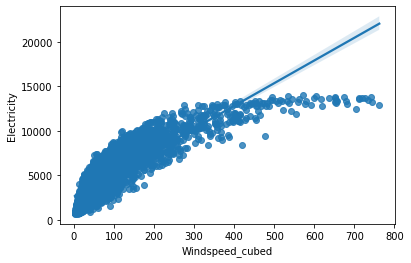

In [72]:
import seaborn as sns

def plot_linear_regression(x, y, z):
    plot = sns.regplot(x=z, y=y, data=x)
    return plot

plot = plot_linear_regression(data, "Electricity", "Windspeed_cubed")

#### **b) Deuxième régression: avec log**


In [73]:
import numpy as np
data['Electricity_log'] = np.log(data['Electricity'])
data['Windspeed_log'] = np.log(data['Windspeed'])

In [74]:
regression_results(data, "Electricity_log", "Windspeed_log")  

                            OLS Regression Results                            
Dep. Variable:        Electricity_log   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                 1.560e+04
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:40:21   Log-Likelihood:                -797.98
No. Observations:                3623   AIC:                             1600.
Df Residuals:                    3621   BIC:                             1612.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.9980      0.019    315.715

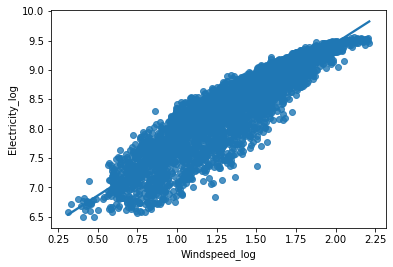

In [75]:
plot = plot_linear_regression(data, "Electricity_log", "Windspeed_log")